In [3]:
import numpy as np
from scipy import stats
import datetime
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from workalendar.usa import UnitedStates
from operator import itemgetter

import pandas as pd

ModuleNotFoundError: No module named 'workalendar'

In [104]:
products = list(np.load('office_products_data.npy', allow_pickle=True))
sample_product = products[24]

In [4]:
class Product:
    '''
    Modularize each product to store each feature as an attribute of a class. 
    Attributes: 
        Mean, Max, Mode, Standard Deviation, Normalized Amazon time Price History
    Methods:
        Holidays overlaid, Ability to detect sales, Derivative of Price History, SCatter plot with various features
        Regression Function
    '''
    
    def __init__(self, product_dict):
        #TODO: Add more asserts
        assert isinstance(product_dict, dict)
        
        self.product_dict = product_dict
        self.amazon_price_history = product_dict['data']['AMAZON']
        
        self.product_df = pd.DataFrame(data=self.amazon_price_history, index=product_dict['data']['AMAZON_time'], columns=['amazon'])
        self.product_df = remove_nan(self.product_df)
        self.product_df['normalized'] = normalize_prices(product_df['amazon'])
        self.product_df['standardized'] = standardize_prices(product_df['amazon'])
        
#         self.mean = np.average(self.amazon_price_history)
#         self.max = max(self.amazon_price_history)
#         self.mode = stats.mode(self.amazon_price_history)
#         self.std = stats.tstd(self.amazon_price_history)
        self.mean = product_df['amazon'].mean()
        self.max = product_df['amazon'].max()
    
    def price_holiday_correlation(self, year=2018):
        #Plot the amazon time price history for the given year and overlay a graph of holidays on top of that
        year_index = [iter_date.year == year for iter_date in self.product_dict['data']['AMAZON_time']]
        year_prices = self.amazon_price_history[np.where(year_index)]
        year_dates = self.product_dict['data']['AMAZON_time'][np.where(year_index)]
        print('Number of price data points for the year %d: %d'% (year, len(year_dates)))
        
        return year_dates, year_prices

    def remove_nan(product):
        '''Remove nan prices from price history

        :param product: price history 
        :type product: pd.DataFrame or pd.Series
        :return: product with nan entries removed
        :rtype: pd.DataFrame or pd.Series
        '''
        assert isinstance(product, (pd.DataFrame,pd.Series))

        return product.dropna()

    def standardize_prices(x):
        '''Given an iterable list of prices, standardize the prices
        Data is centered at 0 mean with unit variance

        :param x: price history
        :type x: (list, np.ndarray, pd.Series)
        :return: z-score standardized price history
        :rtype: np.ndarray
        '''

        assert isinstance(x, (list, np.ndarray, pd.Series))
        assert all(~np.isnan(i) for i in x)

        return stats.zscore(x)

    def normalize_prices(x):
        '''Normalize an iterable list of prices to range (0,1)

        :param x: price history
        :type x: (list, np.ndarray, pd.Series)
        :return: normalized price history
        :rtype: np.ndarray
        '''
        assert isinstance(x, (list, np.ndarray, pd.Series))
        assert all(~np.isnan(i) for i in x)

        return (x-np.min(x))/(np.max(x) - np.min(x))

In [106]:
product_object = Product(sample_product)
print(product_object.amazon_price_history)
print(product_object.mean)
print(product_object.max)
print(product_object.mode)
print(product_object.std)
year = 2018
dates_year, prices_year = product_object.price_holiday_correlation(year)

[11.88   nan 16.99 ... 11.59 11.5  11.38]
nan
20.98
ModeResult(mode=array([11.67]), count=array([43]))
nan
Number of price data points for the year 2018: 141


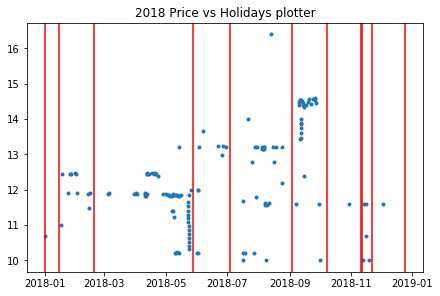

In [108]:
#Plot the dates against prices
fig, ax = plt.subplots(constrained_layout=True)
locator = mdates.AutoDateLocator()
formatter = mdates.AutoDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.plot(dates_year, prices_year, '.')
ax.set_title('%d Price vs Holidays plotter' % (year))

cal=UnitedStates()
us_holidays, _ = zip(*cal.holidays(year))
for holiday in us_holidays:
    plt.axvline(holiday, color = 'r')

In [86]:
# cal=UnitedStates()
# us_holidays, _ = zip(*cal.holidays())
# for holiday in us_holidays:
#     plt.axvline(holiday, color = 'r')
# # print(holidays_year)

In [30]:
a = np.array([1, 3, 4, 5, 6, -1])
print(a[np.where(a > 1)])
del(dates)

[3 4 5 6]
